<a href="https://colab.research.google.com/github/fabiodemo/Deep-Learning-CV-CNN-TL/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download da Base de Dados

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz

--2022-09-23 00:51:53--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1343715595 (1.3G) [application/x-tar]
Saving to: ‘imagewoof2.tgz’

imagewoof2.tgz      100%[===================>]   1.25G  12.2MB/s    in 1m 47s  

2022-09-23 00:53:41 (11.9 MB/s) - ‘imagewoof2.tgz’ saved [1343715595/1343715595]



In [2]:
!tar zxvf imagewoof2.tgz

A saída de streaming foi truncada nas últimas 5000 linhas.
imagewoof2/train/n02115641/n02115641_9529.JPEG
imagewoof2/train/n02115641/n02115641_12039.JPEG
imagewoof2/train/n02115641/n02115641_8768.JPEG
imagewoof2/train/n02115641/n02115641_7188.JPEG
imagewoof2/train/n02115641/n02115641_6633.JPEG
imagewoof2/train/n02115641/n02115641_25018.JPEG
imagewoof2/train/n02115641/n02115641_10706.JPEG
imagewoof2/train/n02115641/n02115641_11814.JPEG
imagewoof2/train/n02115641/n02115641_51135.JPEG
imagewoof2/train/n02115641/n02115641_7409.JPEG
imagewoof2/train/n02115641/n02115641_29257.JPEG
imagewoof2/train/n02115641/n02115641_17997.JPEG
imagewoof2/train/n02115641/n02115641_6473.JPEG
imagewoof2/train/n02115641/n02115641_2963.JPEG
imagewoof2/train/n02115641/n02115641_52488.JPEG
imagewoof2/train/n02115641/n02115641_6536.JPEG
imagewoof2/train/n02115641/n02115641_6166.JPEG
imagewoof2/train/n02115641/n02115641_21519.JPEG
imagewoof2/train/n02115641/n02115641_504.JPEG
imagewoof2/train/n02115641/n02115641_140

In [10]:
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
all_train_paths = glob.glob('/content/imagewoof2/train/*/*.JPEG')

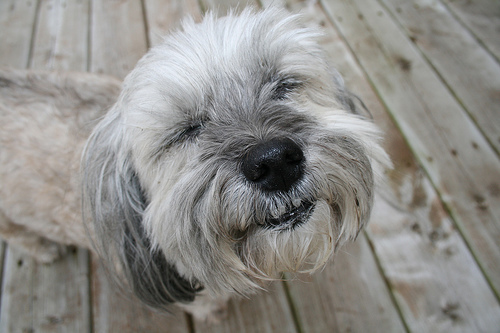

In [12]:
img_path = random.choice(all_train_paths)
Image.open(img_path)

## Declarando ImageDataGenerator

## Declarando Modelo

## Treinar o modelo

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_gen,
          validation_data=valid_gen,
          epochs=3)

Epoch 1/3
283/283 [==============================] - 98s 285ms/step - loss: 0.3326 - accuracy: 0.8993 - val_loss: 0.2225 - val_accuracy: 0.9277
Epoch 2/3
283/283 [==============================] - 78s 277ms/step - loss: 0.1313 - accuracy: 0.9572 - val_loss: 0.2156 - val_accuracy: 0.9262
Epoch 3/3
283/283 [==============================] - 78s 276ms/step - loss: 0.0878 - accuracy: 0.9712 - val_loss: 0.2022 - val_accuracy: 0.9341


## Visualizando Predições